In [47]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os

In [48]:
img = cv2.imread("/Users/apple/face recog model/model/data/virat_kohli/0b43460429.jpg")
img.shape

(900, 1200, 3)

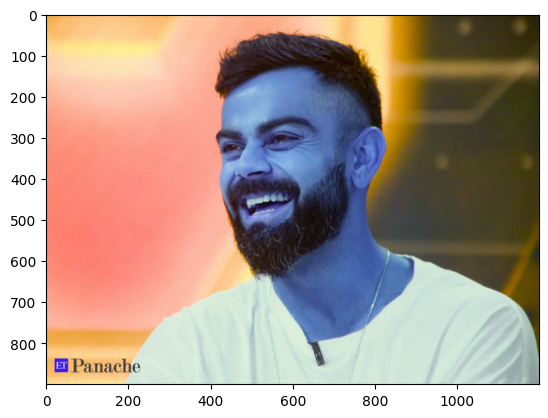

In [49]:
plt.imshow(img)

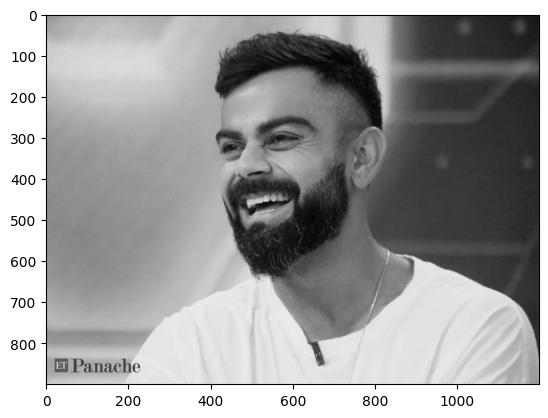

In [50]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')


In [51]:
face_cascade = cv2.CascadeClassifier( '/Users/apple/face recog model/model/opencv/haarcascades/haarcascade_frontalface_default.xml')
eyes_cascade = cv2.CascadeClassifier('/Users/apple/face recog model/model/opencv/haarcascades/haarcascade_eye.xml')
face = face_cascade.detectMultiScale(gray, 1.3, 5)
face

array([[328, 163, 374, 374]], dtype=int32)

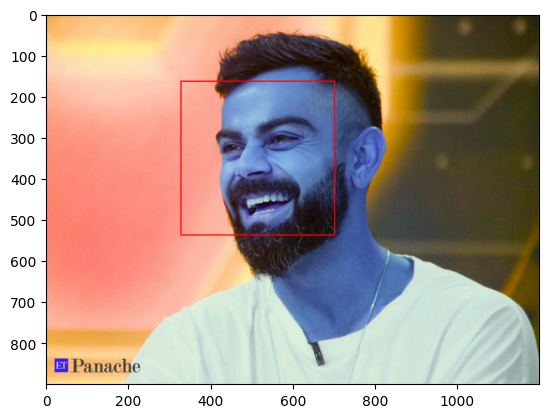

In [52]:
x, y, w, h = face[0]
cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
plt.imshow(img)

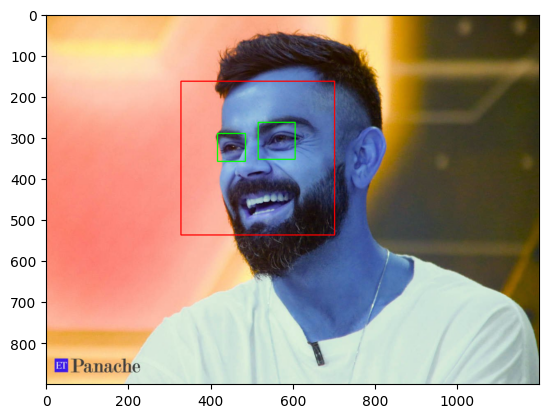

In [53]:
cv2.destroyAllWindows()
for (x, y, w, h) in face:
    face_img = cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
    roi_gray = gray[y:y + h, x:x + w]
    roi_color = img[y:y + h, x:x + w]
    eyes = eyes_cascade.detectMultiScale(roi_gray)
    for (ex, ey, ew, eh) in eyes:
        cv2.rectangle(roi_color, (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 2)

plt.figure()
plt.imshow(face_img, cmap="gray")
plt.show()

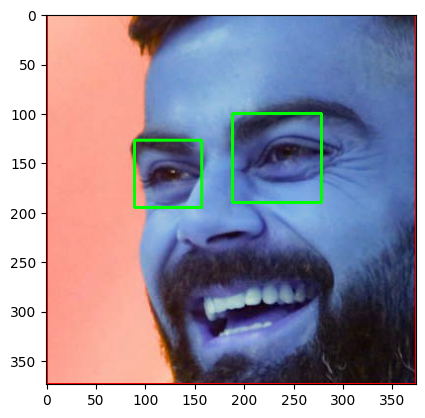

In [54]:
plt.imshow(roi_color)


In [55]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eyes_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color


In [56]:
path_to_data = "/Users/apple/face recog model/model/data"
path_to_cr_data = "/Users/apple/face recog model/model/data/cropped/"

In [57]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir() and os.path.basename(entry.path) != "cropped":
        img_dirs.append(entry.path)

In [58]:
import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data) 
img_dirs

['/Users/apple/face recog model/model/data/maria_sharapova',
 '/Users/apple/face recog model/model/data/virat_kohli',
 '/Users/apple/face recog model/model/data/lionel_messi',
 '/Users/apple/face recog model/model/data/serena_williams',
 '/Users/apple/face recog model/model/data/roger_federer']

In [66]:
cropped_image_dirs = []
celebrity_file_names_dict = {}
for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    celebrity_file_names_dict[celebrity_name] = []
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1

Generating cropped images in folder:  /Users/apple/face recog model/model/data/cropped/maria_sharapova
Generating cropped images in folder:  /Users/apple/face recog model/model/data/cropped/virat_kohli
Generating cropped images in folder:  /Users/apple/face recog model/model/data/cropped/lionel_messi
Generating cropped images in folder:  /Users/apple/face recog model/model/data/cropped/serena_williams
Generating cropped images in folder:  /Users/apple/face recog model/model/data/cropped/roger_federer


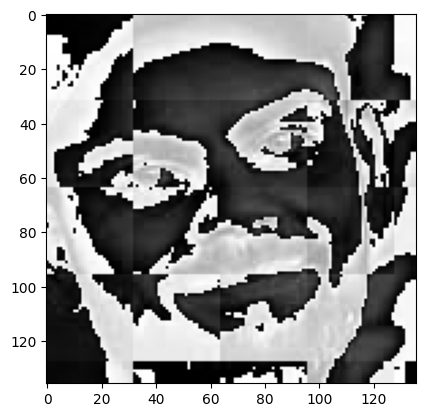

In [60]:
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H
cropped_img = cv2.imread("/Users/apple/face recog model/model/data/cropped/virat_kohli/virat_kohli43.png")
im_har = w2d(cropped_img,'db1',5)
plt.imshow(im_har, cmap='gray')

In [61]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict


{'maria_sharapova': 0,
 'virat_kohli': 1,
 'lionel_messi': 2,
 'serena_williams': 3,
 'roger_federer': 4}

In [62]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        if not os.path.exists(training_image):
            print(f"File not found: {training_image}")
            continue
        img = cv2.imread(training_image)
        if img is None:
            print(f"Could not read image: {training_image}")
            continue
        try:
            scalled_raw_img = cv2.resize(img, (32, 32))
            img_har = w2d(img, 'db1', 5)
            scalled_img_har = cv2.resize(img_har, (32, 32))
            combined_img = np.vstack((scalled_raw_img.reshape(32*32*3, 1), scalled_img_har.reshape(32*32, 1)))
            X.append(combined_img)
            y.append(class_dict[celebrity_name])
        except Exception as e:
            print(f"Error processing {training_image}: {e}")

In [63]:
len(X[0])
y

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4]

In [65]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(148, 4096)